# Introduction to Tensor Networks

Tensor Networks (TNs) are renowned for their ability to approximate ground states in quantum physics.
<br>
Over time, their application has expanded beyond quantum mechanics to a wide range of fields, particularly Machine Learning.

**Overview**
1. Basic operations with tensors
2. Contractions
3. Creation of Tensor Network
4. MNIST classification with MPS

In [33]:
import numpy as np
import jax.numpy as jnp
import jax
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from jax.nn.initializers import *
import quimb.tensor as qtn

from tn4ml.initializers import *
from tn4ml.models.mps import *
from tn4ml.models.model import *
from tn4ml.embeddings import *
from tn4ml.metrics import *
from tn4ml.strategy import *
from tn4ml.util import *

In [34]:
jax.config.update("jax_enable_x64", True)

# Basic operations with tensors
The primary strength of Tensor Networks (TNs) lies in their ability to easily contract and split tensor indices. By taking a large tensor with many indices (a rank-L tensor), we can reconfigure it into a more convenient form. This reconfiguration allows us to apply advanced linear algebra tools that are typically only available for matrices.<br>
<br>

**From Vector to Matrix = Index Splitting**

Imagine having a vector (rank-1 tensor) $T_k$ where 
$k=\underbrace{1,2,\dotsc,i-1,i}_{i},\underbrace{i+1,\dotsc,N}_{j}$. 
<br>
Then, we can see that 
$$ T_k = T_{i,j}$$
Now $T$ is represented as a matrix. 


`data` - raw data array<br>
`inds` - a set of ‘indices’ to label each dimension with<br>
`tags` - name of a tensor

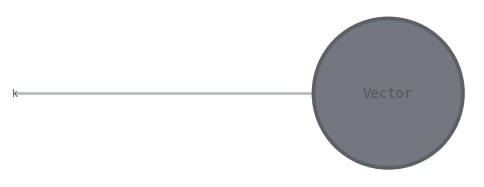

In [35]:
# visualize a vector
data = np.array([1,0,0,1])
inds = ('k')
tags = ('Vector',)

ket = qtn.Tensor(data=data, inds=inds, tags=tags)
ket.draw()

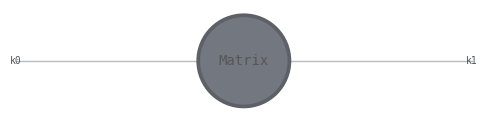

In [36]:
# visualize a matrix
data = data.reshape((2,2)) # reshape vector to matrix
inds = ('k0', 'k1')
tags = ('Matrix',)
ket = qtn.Tensor(data=data, inds=inds, tags=tags)
ket.draw()

**Singular Value Decomposition**

In [37]:
qtn.decomp.svdvals(ket.data) # singular values of the matrix

array([1., 1.])

# Contraction
As we just demonstrated, it's possible to reverse the splitting of tensor indices and fuse two (or more) indices together. By doing so, a rank-2 tensor (a matrix) $T_{i,j}$ can be fused to form a single global index, allowing it to be contracted with another tensor $A_k$.

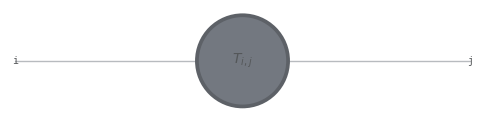

In [38]:
data = np.array([[1,0],[0,1]])
ket = qtn.Tensor(data=data, inds=('i','j'), tags=('$T_{i,j}$',))
ket.draw()

**From Matrix to Vector = Index Fusion**

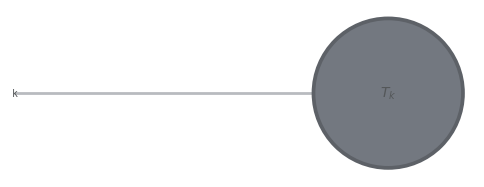

In [39]:
T_k = ket.fuse({'k': ('i','j')}).retag({'$T_{i,j}$':'$T_k$'})
T_k.draw()

This contraction is feasible when the dimensions of the indices being contracted match. Specifically, the dimension of $k$ must equal the combined dimension of $ij$, such as $dim(k) = dim(ij)$.<br>
Thus, the contraction is expressed as:
$$T_{i,j} A_k = T_k A_k = s$$
where s is a rank-$0$ tensor, meaning that is a scalar.

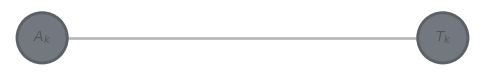

In [40]:
A_k = qtn.Tensor(np.array([1,1,0,0]), inds=('k'), tags=('$A_k$',))
s = A_k | T_k
s.draw()

**Result of contraction vector-vector = scalar**

In [41]:
s.contract()

1

# Create a Tensor Network
(example from Quimb)
1. Create list of tensors
2. Add physical indices to each tensor - `Tensor.new_ind()`
3. Add bonds between neighbouring tensors - `Tensor.new_bond()`
4. Create `TensorNetwork` object with these tensors

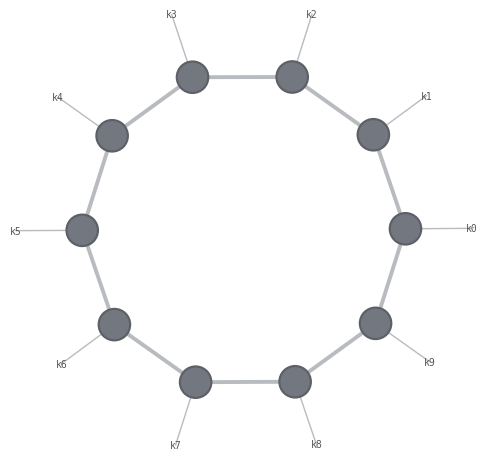

In [42]:
L = 10

# create the nodes, by default just the scalar 1.0
tensors = [qtn.Tensor() for _ in range(L)]

for i in range(L):
    # add the physical indices, each of size 2
    tensors[i].new_ind(f'k{i}', size=2)

    # add bonds between neighbouring tensors, of size 7
    tensors[i].new_bond(tensors[(i + 1) % L], size=7)

mps = qtn.TensorNetwork(tensors)
mps.draw()

### Contraction of TN
Tensor network can be contracted to one tensor of rank $N$, where $N$ is number of tensors in TN.

In [43]:
tensor = mps^all
print(tensor)

Tensor(shape=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2), inds=('k0', 'k1', 'k2', 'k3', 'k4', 'k5', 'k6', 'k7', 'k8', 'k9'), tags=oset([]), backend='numpy', dtype='float64')


# MNIST classification

### Load dataset

**MNIST images** &rarr; grayscale images
- size: 28x28
- 0-9 numbers

In [44]:
train, test = mnist.load_data()

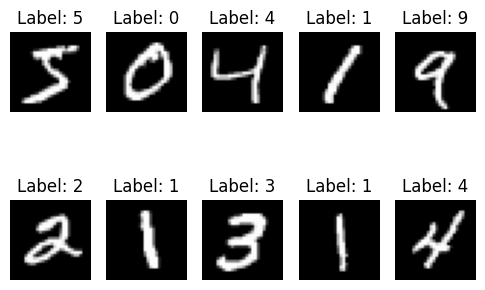

In [45]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 4))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(train[0][i], cmap='gray')
    plt.title(f'Label: {train[1][i]}')
    plt.axis('off')
plt.show()

In [46]:
data = {"X": dict(train=train[0], test=test[0]), "y": dict(train=train[1], test=test[1])}

**Reduce size of the image**

In [47]:
strides = (2,2) # (2,2) for 14x14 images; (4,4) for 7x7 images
pool_size = (2,2)
pool = tf.keras.layers.MaxPooling2D(pool_size=pool_size, strides=strides, padding="same")

In [48]:
X_pooled = pool(tf.constant(data['X']['train'].reshape(-1,28,28,1))).numpy().reshape(-1,14,14)/255.0
X_pooled_test = pool(tf.constant(data['X']['test'].reshape(-1,28,28,1))).numpy().reshape(-1,14,14)/255.0

### Rearrange pixels in zig-zag order
- (from https://arxiv.org/pdf/1605.05775.pdf)

<img src="images/zig-zag.png" alt="MPS Params" width="150" height="150">

In [49]:
def zigzag_order(data):
    data_zigzag = []
    for x in data:
        image = []
        for i in x:
            image.extend(i)
        data_zigzag.append(image)
    return np.asarray(data_zigzag)

In [50]:
train_data = zigzag_order(X_pooled)
test_data = zigzag_order(X_pooled_test)

### Specify number of classes and hot-encode the labels

0 &rarr; [1 0 0 0 0 0 0 0 0 0]<br>
1 &rarr; [0 1 0 0 0 0 0 0 0 0]<br>
<br>
....<br>
<br>
9 &rarr; [0 0 0 0 0 0 0 0 0 1]<br>

In [51]:
n_classes = 10

In [52]:
y_train = integer_to_one_hot(data['y']['train'], n_classes)
y_test = integer_to_one_hot(data['y']['test'], n_classes)

**Take samples for training, validation and testing**

In [53]:
train_size = 6000
test_size = 5000
val_perc = 0.2

In [54]:
# take val_size samples from normal class for validation (X% of training data)
val_size = int(val_perc*train_size)
train_size = int(train_size - val_size)

In [55]:
indices = list(range(len(train_data)))
np.random.shuffle(indices)

train_indices = indices[:train_size]
val_indices = indices[train_size : train_size+val_size]

# train data and validation inputs
train_inputs = np.take(train_data, train_indices, axis=0)
val_inputs = np.take(train_data, val_indices, axis=0)


# train data and validation labels
train_targets = np.take(y_train, train_indices, axis=0)
val_targets = np.take(y_train, val_indices, axis=0)

In [56]:
indices = list(range(len(test_data)))
np.random.shuffle(indices)

test_indices = indices[:test_size]

# test inputs
test_inputs = np.take(test_data, test_indices, axis=0)

# test labels
test_targets = np.take(y_test, test_indices, axis=0)

## TN as ML model
**Specify parameters and initialize a tensor network**

<img src="images/mps_params.png" alt="MPS Params" width="500" height="300">

In [57]:
L = 14*14 # number of tensors in the MPS
initializer = randn(1e-4) # MPS tensors are initialized with random normal values
key = jax.random.key(42)
shape_method = 'noteven'
bond_dim = 10 # bond dimension of the MPS
phys_dim = 3 # when polyomial embedding is used p = 3, when trigonometric embedding is used p = 2
class_dim = 10 # number of classes
index_class = L//2 if L%2==0 else L//2+1
cyclic = False
add_identity = True
boundary = 'obc' # open boundary conditions

In [59]:
model = MPS_initialize(L,
                    initializer=initializer,
                    key=key,
                    shape_method=shape_method,
                    bond_dim=bond_dim,
                    phys_dim=phys_dim,
                    cyclic=False,
                    add_identity=True,
                    class_dim=class_dim,
                    class_index=index_class,
                    boundary=boundary,
                    dtype=jnp.float64)

**Define training parameters**

In [61]:
def cross_entropy_loss(*args, **kwargs):
    return OptaxWrapper(optax.softmax_cross_entropy)(*args, **kwargs).mean()

In [ ]:
# training parameters
optimizer = optax.adam
strategy = 'global' # Global Gradient Descent
loss = cross_entropy_loss
train_type = TrainingType.SUPERVISED
embedding = polynomial(degree=2) # if using randn
learning_rate = 1e-4

In [64]:
model.configure(optimizer=optimizer, strategy=strategy, loss=loss, train_type=train_type, learning_rate=learning_rate)

In [65]:
epochs = 50
batch_size = 256

<img src="images/mps_models.png" alt="MPS Params" width="150" height="250">

In [66]:
history = model.train(train_inputs,
                    targets = train_targets,
                    val_inputs = val_inputs,
                    val_targets = val_targets,
                    epochs = epochs,
                    batch_size = batch_size,
                    embedding = embedding,
                    normalize = True,
                    cache=False, # for now True not working for classification
                    display_val_acc=True,
                    val_batch_size=64,
                    dtype = jnp.float64)

epoch:  42%|████▏     | 21/50 [07:27<09:15, 19.16s/it, loss=1.4929420333762604, val_loss=1.5167269819043352, val_acc=0.929]

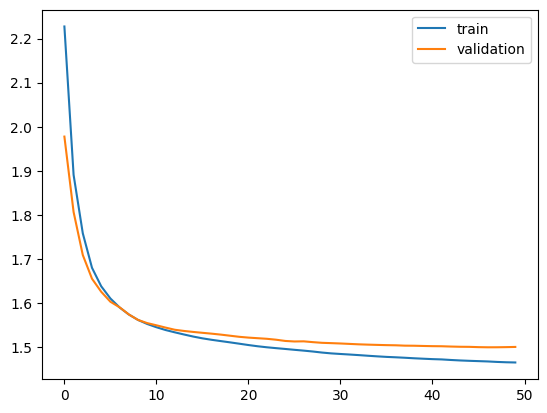

In [32]:
import matplotlib.pyplot as plt
# plot loss
plt.figure()
plt.plot(range(len(model.history['loss'])), model.history['loss'], label='train')
plt.plot(range(len(model.history['val_loss'])), model.history['val_loss'], label='validation')
plt.legend()
plt.show()

**Save model**

In [33]:
model.save('model', 'tests/mnist_class', tn=True)

### Evaluate

Calculate accuracy of the classification

In [34]:
model.accuracy(test_inputs, test_targets, embedding=embedding, batch_size=64)

0.9439102564102564